In [ ]:
# Fill in your name using the format below and student ID number
your_name = "Antonissen, Luc"
student_id = "0908502"

In [ ]:
from platform import python_version
print(python_version())
import sys
print(sys.executable)

In [3]:
# Before submission, set this to True so that you can render and verify this notebook without training deep learning models.
# Any deep learning models will be trained from file instead.
stop_training = False

In [4]:
# Uncomment the following line to run in Google Colab
# !pip install --quiet openml 

In [5]:
# Uncomment the following line to run in Google Colab
#%tensorflow_version 2.x
import tensorflow as tf

In [6]:
tf.config.experimental.list_physical_devices('GPU') # Check whether GPUs are available

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
# REMOVE THIS CELL!!!
# from tensorflow.python.client import device_lib

# def get_available_gpus():
#     local_device_protos = device_lib.list_local_devices()
#     return [x.name for x in local_device_protos if x.device_type == 'GPU']
# get_available_gpus()

In [8]:
%matplotlib inline
import openml as oml
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [9]:
from packaging import version
import sklearn
import tensorflow
sklearn_version = sklearn.__version__
tensorflow_version = tensorflow.__version__
if version.parse(sklearn_version) < version.parse("0.22.0"):
    print("scikit-learn is outdated. Please update now!")
if version.parse(tensorflow_version) < version.parse("2.1.0"):
    print("Tensorflow is outdated. This is version {}. Please update to 2.1.".format(tensorflow_version))
else:
    print("Hi{}, Looks good. You may continue :)".format(your_name.split(",")[1]))

Hi Luc, Looks good. You may continue :)


In [10]:
from tensorflow.keras import models, layers, regularizers, constraints, optimizers, backend, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import image
import cv2
import pickle
import gzip
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

# Assignment 3

### Choice of libraries
We recommend to use Tensorflow in this assignment since that is what we covered in the labs. If you feel confident using PyTorch (and Skorch for the scikit-learn wrapper), that is allowed too, as long as you are able to implement the requested functions and return the requested data. Read the assignment carefully and ensure that you can. Note that you may also need to do a bit more work to implement certain helper functions and wrappers.

### Storing and submitting files
You must be able to store your models and submit them to GitHub Classroom. The evaluation functions used in this notebook will automatically store models for you.

If you want to run and solve the notebook on your local machine/laptop, fill in the path 'base_dir' to your assignment folder into the next cell.

If you use Colab, we recommend that you link it to your Google Drive:  
* Upload the assignment folder to your Google Drive (+ New > Folder Upload)
* Open Colab in a browser, open the 'Files' menu in the left sidebar, and click 'Mount Drive'
  * At this point you may need to authenticate
* Fill in the path to your assignment folder below
  * It's likely '/content/drive/My Drive/assignment-3-yourname'

In [11]:
#base_dir = '/content/drive/My Drive/TestAssignment' # For Google Colab
base_dir = './'

In [12]:
#Uncomment to link Colab notebook to Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

### Using GPUs
While you can solve this assignment on a CPU, using a GPU will speed things up training quite a bit. If you have a local GPU, you can use that. If you don't, we recommend Google Colab. When you are in Colab:
* In Runtime > Change runtime type, select the GPU under Hardware Accelerator
* Run the 3rd cell on the top of this notebook to check that the GPU is found.

Note that Colab may not always have GPUs ready all the time, and may deny you a GPU when you have used them a lot. When you are temporarily 'locked out', you can switch to a non-GPU runtime or to a local instance of Jupyter running on your machine.

### Constraints
* Your stored models should not be larger than 100MB when stored in file. GitHub will not allow uploading if they are.
* When questions ask you to provide an explanation, it should be less than 500
characters long. Some questions have a higher limit. Always answer in full sentences.
* Don't train for more than 100 epochs, i.e. don't throw excessing computational resources at the problem. If your model hasn't converged by then, think of ways it could be made to converge faster. In this assignment you are not after the last tiny improvement, you can stop when learning curves flatten out. Do at least 5 epochs to get a reasonable learning curve.

### Grading
Grading is based on the following aspects:
* Correctness in answering the question. Carefully read the question and answer
what is asked for. Train your models on the correct data. It should be clear on which data should be trained, but ask when in doubt. When something is not defined (e.g. the number of epochs or batch size), you can freely choose them.
* Clarity of your explanations. Write short but precise descriptions of what you did and why. Give short but clear explanations of the observed performance. 
After your explanation, your approach and model should make perfect sense. Refrain from using symbols as substitute for words in your explanation (e.g. no: "More layers -> more parameters" yes: "More layers mean more parameters"). 
* Part of your grade depends on how well your model performs. When the question says 'you should at least get x%', x% will give you a good but not the maximal grade. You can get the full grade when you are close to what is the expected maximal performance. You don't need to invest lots of effort into the last tiny improvement, though. Unless specified, we look at the accuracy on the validation set. If your learning curves are very erratic we'll compute a score based on the smoothed curves (i.e. single peaks don't count).
* The weight of each question is indicated. Take this into account when planning your time.

### Other tips
* Don't wait until the last minute to do the assignment. The models take time to train, most questions will require some thinking, and some require you to read up on some new concepts.
* Take care that you upload the results as requested. You need to submit not only the notebooks but also the trained models and learning curves (training histories). Be sure to run the verification script and check that all the results are included.
* We provide an evaluation function that also stored models to disk. After you are done training the model, set the 'train' attribute to False so that the model doesn't train again (and loads from file instead) when you restart and rerun your notebook.
* Explore. For many questions we'll ask you to explain your model design decisions. You cannot magically know the best solutions but you can experiment
based on your understanding and make decisions based on both your knowledge and experiments. Your explanation is at least as important as the performance of your model.
* Be original. We will check for plagiarism between student submissions.

### Data
The [Street View House Numbers Dataset](https://www.openml.org/d/41081) contains 32-by-32 RGB images centered around a single digit of a house number appearing in Google Street View. Many of the images do contain some distractors at the sides. It consists of 10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 10. Your goal is to build models that recognize the correct digit.

If you use Colab, uncomment the following to cache the dataset inside the VM. This will make reloading faster if you need to restart your notebook. After longer periods of inactivity, your VM may be recycled and the cache lost, in which case the dataset will be downloaded again. Also note that this dataset is about 1Gb large, and will take even more space in memory. You may need to switch to a high-RAM environment (Colab will ask you if you hit the limit).

In [13]:
# Use OpenML caching in Colab
# On your local machine, it will store data in a hidden folder '~/.openml'
#import os
#oml.config.cache_directory = os.path.expanduser('/content/cache')

In [14]:
# Download Streetview data. Takes a while (several minutes), and quite a bit of
# memory when it needs to download. After caching it loads faster.
# https://www.openml.org/d/41081
SVHN = oml.datasets.get_dataset(41081)
X, y, _, _ = SVHN.get_data(dataset_format='array',
    target=SVHN.default_target_attribute)

Reshape, sample and split the data

In [15]:
from tensorflow.keras.utils import to_categorical

Xr = X.reshape((len(X),32,32,3))
Xr = Xr / 255.
yr = to_categorical(y)

In [16]:
# DO NOT EDIT. DO NOT OVERWRITE THESE VARIABLES.
from sklearn.model_selection import train_test_split
# We do an 80-20 split for the training and test set, and then again a 80-20 split into training and validation data
X_train_all, X_test, y_train_all, y_test = train_test_split(Xr,yr, stratify=yr, train_size=0.8, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_all,y_train_all, stratify=y_train_all, train_size=0.8, random_state=1)
evaluation_split = X_train, X_val, y_train, y_val

In [17]:
# Luminance-preserving RGB to greyscale conversion
def rgb2gray(X):
    return np.expand_dims(np.dot(X, [0.2990, 0.5870, 0.1140]), axis=3)

# Replace with the preprocessed data
preprocessed_split = rgb2gray(X_train), rgb2gray(X_val), y_train, y_val

Check the formatting - and what the data looks like

In [18]:
# from random import randint

# # Takes a list of row ids, and plots the corresponding images
# # Use grayscale=True for plotting grayscale images
# def plot_images(X, y, grayscale=False):
#     fig, axes = plt.subplots(1, len(X),  figsize=(10, 5))
#     for n in range(len(X)):
#         if grayscale:
#             axes[n].imshow(X[n], cmap='gray')
#         else:
#             axes[n].imshow(X[n])
#         axes[n].set_xlabel((np.argmax(y[n])+1)%10) # Label is index+1
#         axes[n].set_xticks(()), axes[n].set_yticks(())
#     plt.show();

# images = [randint(0,len(X_train)) for i in range(5)]
# X_random = [X_train[i] for i in images]
# y_random = [y_train[i] for i in images]
# plot_images(X_random, y_random)

In [19]:
labels = {0:1, 1:2, 2:3, 3:4, 4:5, 5:6, 6:7, 7:8, 8:9, 9:0}

### Evaluation harness
We provide an evaluation function 'run_evaluation' that you should use to 
evaluate all your models. It also stores the trained models to disk so that
your submission can be quickly verified, as well as to avoid having to train
them over and over again. Your last run of the evaluation function (the last one
stored to file), is the one that will be evaluated. The 'train' argument indicates whether to train or to load from disk. We have provided helper functions for saving and loading models to/from file, assuming you use TensorFlow. If you use PyTorch you'll have to adapt them.

In [20]:
import os
import pickle
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model # for use with tensorflow

def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')

def load_model_from_file(base_dir, name, extension='.h5'):
    """ Loads a model from a file. The returned model must have a 'fit' and 'summary'
    function following the Keras API. Don't change if you use TensorFlow. Otherwise,
    adapt as needed. 
    Keyword arguments:
    base_dir -- Directory where the models are stored
    name -- Name of the model, e.g. 'question_1_1'
    extension -- the file extension
    """
    try:
        model = load_model(os.path.join(base_dir, name+extension))
    except OSError:
        shout("Saved model could not be found. Was it trained and stored correctly? Is the base_dir correct?")
        return False
    return model

def save_model_to_file(model, base_dir, name, extension='.h5'):
    """ Saves a model to file. Don't change if you use TensorFlow. Otherwise,
    adapt as needed. 
    Keyword arguments:
    model -- the model to be saved
    base_dir -- Directory where the models should be stored
    name -- Name of the model, e.g. 'question_1_1'
    extension -- the file extension
    """
    model.save(os.path.join(base_dir, name+extension))

# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

# DO NOT EDIT
def run_evaluation(name, model_builder, data, base_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data in given as a generator or not
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}
    if train and not stop_training: # Train anew
        shout("Training the model", verbose)
        if generator:
            generator, X_val, y_val = data
            history = model.fit(generator, epochs=epochs, batch_size=batch_size,
                              steps_per_epoch=steps_per_epoch, verbose=1, 
                              validation_data=(X_val, y_val))
            learning_curves = history.history
        else:
            X_train, X_val, y_train, y_val = data
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                              verbose=1, validation_data=(X_val, y_val))
            learning_curves = history.history
        shout("Saving to file", verbose)
        save_model_to_file(model, base_dir, name)
        with open(os.path.join(base_dir, name+'.p'), 'wb') as file_pi:
            pickle.dump(learning_curves, file_pi)
        shout("Model stored in "+base_dir, verbose)
    else: # Load from file
        shout("Loading model from file", verbose)
        model = load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
            return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
            return
        shout("Success!", verbose)
    # Report
    print(model.summary())
    lc = pd.DataFrame(learning_curves)
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    print(lc.apply(minMax))

## Part 1. Dense networks (10 points)

### Question 1.1: Baseline model (4 points)
- Build a dense network (with only dense layers) of at least 3 layers that is shaped like a pyramid: The first layer must have many nodes, and every subsequent layer must have increasingly fewer nodes, e.g. half as many. Implement a function 'build_model_1_1' that returns this model.
- You can explore different settings, but don't use any preprocessing or regularization yet. You should be able to achieve at least 70% accuracy, but more is of course better. Unless otherwise stated, you can use accuracy as the evaluation metric in all questions.
* Add a small description of your design choices (max. 500 characters) in 'answer_q_1_1': explain what you did and also why. Also discuss the performance of the model. Is it working well? Both the performance of the model and your explanations matter.
- The name of the model should be 'model_1_1'. Evaluate it using the 'run_evaluation' function. For this question, you should not use more than 50 epochs.

Loading model from file
Success!
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 3413)              10488149  
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 3413)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1706)              5824284   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1706)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 853)               1456071   
_________________________________________________________________
leaky_re_lu_2 (LeakyReL

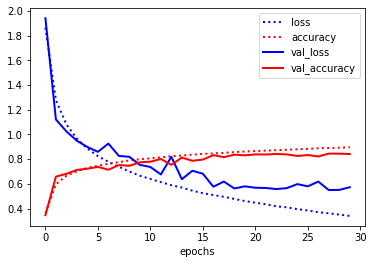

In [21]:
def build_model_1_1():
    model = models.Sequential()
    model.add(layers.Reshape((32**2*3,), input_shape=(32,32,3)))
    model.add(layers.Dense(2**12//1.2))
    model.add(layers.LeakyReLU(.01))
    model.add(layers.Dense(2**11//1.2))
    model.add(layers.LeakyReLU(.01))
    model.add(layers.Dense(2**10//1.2))
    model.add(layers.LeakyReLU(.01))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='sgd',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

run_evaluation("model_1_1", build_model_1_1, evaluation_split, base_dir, 
               train=False, epochs=30, batch_size=32)
answer_q_1_1 = """I used 3 dense layers with a Leaky Relu activation function and sgd as optimizer with the default alpha.
The first layer has 4096 nodes and the next two have increasingly half the layers of the former layer.
These settings are chosen, because they yielded the best results in terms of accuracy on the validation score.
I have experimented with different #layers, layer sizes, activation functions, optimizers and epochs which gave me the validation accuracy of 84% in the end.
"""
print("Answer is {} characters long".format(len(answer_q_1_1)))

### Question 1.2: Preprocessing (2 points)
Rerun the model, but now preprocess the data first by converting the images to 
greyscale. You can use the helper function below. If you want to do additional 
preprocessing, you can do that here, too.
* Store the preprocessed data as a tuple `preprocessed_split`
* Rerun and re-evaluate your model using the preprocessed data.
  * For the remainder of the assignment, always use the preprocessed data
* Explain what you did and interpret the results in 'answer_q_1_2'. Is the model
  better, if so, why?

In [22]:
# Luminance-preserving RGB to greyscale conversion
def rgb2gray(X):
    return np.expand_dims(np.dot(X, [0.2990, 0.5870, 0.1140]), axis=3)

# Replace with the preprocessed data
preprocessed_split = rgb2gray(X_train), rgb2gray(X_val), y_train, y_val

Loading model from file
Success!
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 1024)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 3413)              3498325   
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 3413)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 1706)              5824284   
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 1706)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 853)               1456071   
_________________________________________________________________
leaky_re_lu_14 (Leaky

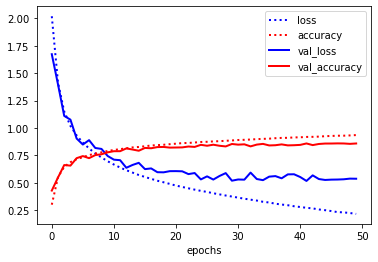

In [23]:
# Adjusted model
def build_model_1_2():
    model = models.Sequential()
    model.add(layers.Reshape((32**2*1,), input_shape=(32,32,1)))
    model.add(layers.Dense(2**12//1.2))
    model.add(layers.LeakyReLU(.01))
    model.add(layers.Dense(2**11//1.2))
    model.add(layers.LeakyReLU(.01))
    model.add(layers.Dense(2**10//1.2))
    model.add(layers.LeakyReLU(.01))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='sgd',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Evaluate. Use a new name 'model_1_2' to not overwrite the previous trained model
run_evaluation("model_1_2", build_model_1_2, preprocessed_split, base_dir, 
               train=False, epochs=50, batch_size=32)
answer_q_1_2 = """The model performs very similar to the rgb model as seen in the output graph.
The accuracy is improved from 84% to 86%.
I tried other pre-processing techniques like max pooling and average pooling (so before training, not in the seq model), but they made the model perform worse (around 83% accuracy and lower).
Color doesn't seem to be very relevant in this model and the model performs even bettwe with gray scaling, most likely because there are fewer input parameters.
"""
print("Answer is {} characters long".format(len(answer_q_1_2)))

### Question 1.3: Regularization and tuning (4 points)
* Regularize the model. You can explore (and combine) different techniques. What works best?
* Tune other hyperparameters (e.g. learning rate, batch size,...) as you see fit.
* Explain your findings and final design decisions. Retrain the model again on the preprocessed data and discuss the results.
* Return your model in function 'build_model_1_3' and write your answer in 'answer_q_1_3'

Loading model from file
Success!
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 3413)              3498325   
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 3413)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 1706)              5824284   
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 1706)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 853)               1456071   
_________________________________________________________________
leaky_re_lu_11 (Leaky

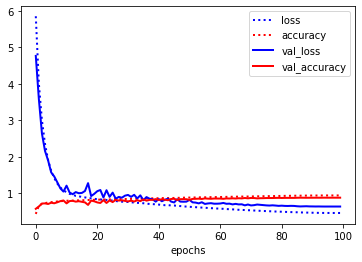

In [24]:
def build_model_1_3():
    model = models.Sequential()
    model.add(layers.Reshape((32**2*1,), input_shape=(32,32,1)))
    model.add(layers.Dense(2**12//1.2, kernel_regularizer=regularizers.l2(.001)))
    model.add(layers.LeakyReLU(.01))
    model.add(layers.Dense(2**11//1.2, kernel_regularizer=regularizers.l2(.001)))
    model.add(layers.LeakyReLU(.01))
    model.add(layers.Dense(2**10//1.2, kernel_regularizer=regularizers.l2(.001)))
    model.add(layers.LeakyReLU(.01))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer=optimizers.SGD(learning_rate=optimizers.schedules.PolynomialDecay(initial_learning_rate=.02,
                                                                                              decay_steps=95*497,
                                                                                              end_learning_rate=.0001,
                                                                                              power=1.5),
                                           momentum=.9,
                                           nesterov=True),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

run_evaluation("model_1_3", build_model_1_3, preprocessed_split, base_dir, 
               train=False, epochs=100, batch_size=128)
answer_q_1_3 = """Dropout and batch normalization yielded 87% accuracy on the val set, but L2 was slightly better with 88%.
SGD still performed best with adam as a close second. I've change sgd to use nesterov momentum and learning rate decay starting with 0.02.
The batch size is increased, but makes training slower so more epochs were needed.
"""
print("Answer is {} characters long".format(len(answer_q_1_3)))

## Part 2. Convolutional neural networks (10 points)
### Question 2.1: Design a ConvNet (7 points)
- Build a sequential convolutional neural network. Try to achieve the best validation accuracy you can. You should be able to get at least 90% accuracy. You can use any depth, any combination of layers, and any kind of regularization and tuning. 
- Add a description of your design choices in 'answer_q_2_1': explain what you did and also why. Also discuss the performance of the model. Is it working well? Both the performance of the model and your explanations matter.
- You are allowed **800** characters for this answer (but don’t ramble).
- The name of the model should be 'model_2_1'. Evaluate it using the 'run_evaluation' function and the preprocessed data.

Loading model from file
Success!
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 29, 29, 32)        544       
_________________________________________________________________
batch_normalization_27 (Batc (None, 29, 29, 32)        128       
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 29, 29, 32)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
batch_normalization_28 (Batc (None, 29, 29, 64)        256       
_________________________________________________________________
leaky_re_lu_28 (Leaky

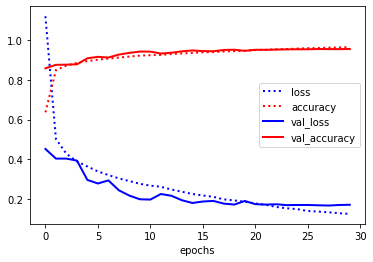

In [25]:
def build_model_2_1():
    model = models.Sequential()
    model.add(layers.Conv2D(2**5, (4, 4), padding='valid', kernel_constraint=constraints.MaxNorm(2), input_shape=(32, 32, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(.01))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(2**6, (3, 3), padding='same', kernel_constraint=constraints.MaxNorm(2)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(.01))
    model.add(layers.Conv2D(2**6, (3, 3), padding='same', kernel_constraint=constraints.MaxNorm(2)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(.01))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))
              
    model.add(layers.Conv2D(2**6, (3, 3), padding='same', kernel_constraint=constraints.MaxNorm(2)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(.01))
    model.add(layers.Conv2D(2**6, (3, 3), padding='same', kernel_constraint=constraints.MaxNorm(2)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(.01))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.4))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(2**8, kernel_constraint=constraints.MaxNorm(2)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(.01))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2**7, kernel_constraint=constraints.MaxNorm(2)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(.01))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, kernel_constraint=constraints.MaxNorm(2), activation='softmax'))
    model.compile(optimizer=optimizers.Adam(learning_rate=optimizers.schedules.PolynomialDecay(initial_learning_rate=.002,
                                                                                               decay_steps=30*993,
                                                                                               end_learning_rate=.0001,
                                                                                               power=1.5)),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

run_evaluation("model_2_1", build_model_2_1, preprocessed_split, base_dir, 
               train=False, epochs=30, batch_size=64)
answer_q_2_1 = """ In the conv net i've chosen for dropout, batchnormalization and maxnorm as regularization instead of l2, because it works a lot better. 
The first conv layer uses a valid padding with the other conv layers same padding to keep the same size.
After the first conv layer there are 2 blocks each consisting of 2 conv layers and a max pooling layer in the end.
After the conv layers there are 2 dense layers before the last dense sofmax layer which does the predictions.
For this model the adam optimizer with learning rate decay performed better than SGD and gets a result of 96% accuracy on the validation data.
LeakyRelu still works best for the activations with batchnormalization between the dense layer and the activation function.
"""
print("Answer is {} characters long".format(len(answer_q_2_1)))

### Question 2.2: Data Augmentation (3 points)

- Augment the preprocessed training data. You can explore using image shifts, rotations, zooming, flips, etc. What works well, and what does not?
- Evaluate the model from question 2.1 with the augmented data using the 'run_evaluation' function. Store the new trained model as 'model_2_2'.
- Add a description of your design choices in 'answer_q_2_2': explain what you did and also why. Also discuss the performance of the model.

In [26]:
train_data_gen = ImageDataGenerator(
    width_shift_range=.05,
    height_shift_range=.05
)
X_train_pre, X_val_pre, y_train, y_val= preprocessed_split
train_data_gen.fit(X_train_pre)
it_train = train_data_gen.flow(x=X_train_pre, y=y_train, batch_size=64)
steps = int(X_train_pre.shape[0] / 64)

augmented_split = it_train, X_val_pre, y_val

Loading model from file
Success!
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_86 (Conv2D)           (None, 29, 29, 32)        544       
_________________________________________________________________
batch_normalization_118 (Bat (None, 29, 29, 32)        128       
_________________________________________________________________
leaky_re_lu_118 (LeakyReLU)  (None, 29, 29, 32)        0         
_________________________________________________________________
dropout_86 (Dropout)         (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
batch_normalization_119 (Bat (None, 29, 29, 64)        256       
_________________________________________________________________
leaky_re_lu_119 (Lea

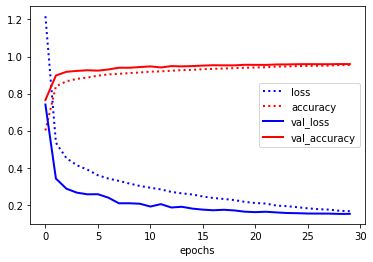

In [27]:
run_evaluation("model_2_2", build_model_2_1, augmented_split, base_dir,
               steps_per_epoch=steps, generator=True,
               train=False, epochs=30, batch_size=64)
answer_q_2_2 = """I've tested all possible data augmentation methods possible in the ImageDataGenerator except for brightness_range since it doesn't work on the grayscale images with PIL.
Only width_shift_range and height_shift_range with a very small range (.05) gave improved results.
The final model performs a tiny bit better than the model without data augmentation, 95,9% and 95,6% respecively.
"""
print("Answer is {} characters long".format(len(answer_q_2_2)))

## Part 3. Model interpretation (10 points)
### Question 3.1: Interpreting misclassifications (2 points)
Study which errors are still made by your last model (model_2_2) by evaluating it on the test data. You do not need to retrain the model.
* What is the accuracy of model_2_2 on the test data? Store this in 'test_accuracy_3_1'.
* Plot the confusion matrix in 'plot_confusion_matrix' and discuss which classes are often confused.
* Visualize the misclassifications in more depth by focusing on a single
class (e.g. the number '2') and analyse which kinds of mistakes are made for that class. For instance, are the errors related to the background, noisiness, etc.? Implement the visualization in 'plot_misclassifications'.
* Summarize your findings in 'answer_q_3_1'

In [28]:
model = load_model_from_file(base_dir, "model_2_2")

test_accuracy_3_1 = model.evaluate(rgb2gray(X_test), y_test)[1]
# y_pred = model.predict(rgb2gray(X_test))
# misclassified_samples = np.nonzero(np.argmax(y_test, axis=1) != np.argmax(y_pred, axis=1))[0]
test_accuracy_3_1

621/621 [==============================] - 5s 8ms/step - loss: 0.1528 - accuracy: 0.9591


0.9590592980384827

In [29]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix():
    model = load_model_from_file(base_dir, "model_2_2")
    y_pred = model.predict(rgb2gray(X_test))
    misclassified_samples = np.nonzero(np.argmax(y_test, axis=1) != np.argmax(y_pred, axis=1))[0]
    
    cm = confusion_matrix(np.argmax(y_test, axis=1),np.argmax(y_pred, axis=1), labels=np.arange(10))
    fig, ax = plt.subplots()
    im = ax.imshow(cm)
    ax.set_xticks(np.arange(10)), ax.set_yticks(np.arange(10))
    ax.set_xticklabels(list(labels.values()), rotation=0, ha="right")
    ax.set_yticklabels(list(labels.values()))
    ax.set_ylabel('True')
    ax.set_xlabel('Predicted')
    for i in range(100):
        ax.text(int(i/10),i%10,cm[i%10,int(i/10)], ha="center", va="center", color="w")
        
    plt.show()
    

def plot_misclassifications():
    number = 2
    model = load_model_from_file(base_dir, "model_2_2")
    y_pred = model.predict(rgb2gray(X_test))
    misclassified_samples = np.nonzero(np.argmax(y_test, axis=1) != np.argmax(y_pred, axis=1))[0]

    number_index = {val:el for el, val in labels.items()}[number]
    indices = np.where(np.argmax(y_test, axis=1) == number_index)[0]
    misclassified_samples_number = np.array(list(set(misclassified_samples) & set(indices)))
    
    fig, axes = plt.subplots(1, 10,  figsize=(20, 5))
    for nr, i in enumerate(misclassified_samples_number[:10]):
        axes[nr].imshow(X_test[i])
        axes[nr].set_xlabel("Predicted: %s,\n Actual : %s" % (labels[np.argmax(y_pred[i])], labels[np.argmax(y_test[i])]))
        axes[nr].set_xticks(()), axes[nr].set_yticks(())
    
    plt.show()

answer_q_3_1 = """The test accuracy of model 2.2 is 96%, which is similar to the val data, so the data isn't overfitted on the validation set.
The confusion matrix shows that the model has trouble with differences (3,5) and (1,7), but there are no extreme wrong predictions where there is an obvious mistake in the model.
The misclassifications show images which are difficult to see even with human eyes. This is not surprising, with human eyes the accuracy is ~97% so the model comes close to human performance.
"""
print("Answer is {} characters long".format(len(answer_q_3_1)))

Answer is 496 characters long


In [30]:
# plot_confusion_matrix()
# plot_misclassifications()

### Question 3.2: Visualizing activations (4 points)
* Implement a function `plot_activations()` that returns the most interesting activations (feature maps). Select the first example from the test set. Retrieve and visualize the activations of model 2_2 for that example (make sure you load that model in the function), for every filter for different convolutional layers (at different depths in the network).
* Give an explanation (as detailed as you can) about your observations in 'answer_q_3_2'. Is your model indeed learning something useful?

In [31]:
# # model.summary()
# for layer in model.layers:
#     print(layer.name)

In [32]:
# img_tensor = rgb2gray(X_test)[0]
# img_tensor = np.expand_dims(img_tensor, axis=0) 
# layer_outputs = [layer.output for layer in model.layers[:15]]#
# activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
# activations = activation_model.predict(img_tensor)

# layer_names = []
# for layer in model.layers:
#     layer_names.append(layer.name)

In [33]:
def plot_activations():
    images_per_row = 16
    model = load_model_from_file(base_dir, "model_2_2")
    
    img_tensor = rgb2gray(X_test)[0]
    img_tensor = np.expand_dims(img_tensor, axis=0) 
    layer_outputs = [layer.output for layer in model.layers]
    activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
    
    layer_names = [layer.name for layer in model.layers]
    activations = activation_model.predict(img_tensor)
    
    layer_index, conv2d_layer = 0, 0
    for layer_name, layer_activation in zip(layer_names, activations):
        layer_index += 1
        
        if 'conv2d_' in layer_name:
            conv2d_layer += 1
            
            n_features = layer_activation.shape[-1]
            size = layer_activation.shape[1]
            n_cols = n_features // images_per_row
            display_grid = np.zeros((size * n_cols, images_per_row * size))

            for col in range(n_cols):
                for row in range(images_per_row):
                    channel_image = layer_activation[0,
                                                     :, :,
                                                     col * images_per_row + row]
                    channel_image -= channel_image.mean()
                    channel_image /= channel_image.std()
                    channel_image *= 64
                    channel_image += 128
                    channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                    display_grid[col * size : (col + 1) * size,
                                 row * size : (row + 1) * size] = channel_image

            scale = 1. / size
            plt.figure(figsize=(scale * display_grid.shape[1],
                                scale * display_grid.shape[0]))
            plt.title("Activation of conv2d layer {} ({}: {})".format(conv2d_layer, layer_index, layer_name))
            plt.grid(False)
            plt.imshow(display_grid, aspect='auto', cmap='viridis')

    plt.show()
    

answer_q_3_2 = """It is clear that all the activation layers are used, since the all represent something and dont show an image with just one color.
The first 3 layers focus on the edges of the colors and that way try to focus on the shape of the number.
The last 2 layers (4 and 5) it is not possible to recognise the actual number anymore and the colors show that each dimension has a very specific area to focus on.
From the plots all layers and dimensions seem to be usefull and dimensions are not the same.
"""
print("Answer is {} characters long".format(len(answer_q_3_2)))

Answer is 494 characters long


In [34]:
# plot_activations()

### Question 3.3: Visualizing activations (4 points)
* Again, select the first example from the test set, and the trained model_2_2.
* Implement a function `plot_activation_map()` that builds and shows a class activation map for your last convolutional layer that highlights what the model is paying attention to when classifying the example.
* If possible, superimpossible the activation map over the image. If not, plot
them side by side. Implement a function 'plot_3_3' that returns the entire plot.

In [35]:
def plot_activation_map():
    images_per_row = 16
    heatmap_intensity = .25
        
    backend.clear_session()
    tf.compat.v1.disable_eager_execution()
    
    model = load_model_from_file(base_dir, "model_2_2")
    X_example = rgb2gray(np.expand_dims(X_test[0], axis=0))[0]
    y_example = y_test[0]
    
    def get_last_conv2d_layer():
        for layer in model.layers[::-1]:
            if 'conv2d_' in layer.name:
                return layer
    

    last_conv2d_layer = get_last_conv2d_layer()    
    grads = backend.gradients(model.output, last_conv2d_layer.output)[0]
    pooled_grads = backend.mean(grads, axis=(0, 1, 2))
    iterate = backend.function([model.input], [pooled_grads, last_conv2d_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([np.expand_dims(X_example, axis=0)])
    
    for i in range(64):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)    
    
    img = np.concatenate((X_example, X_example, X_example), axis=2) * 255
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = heatmap * heatmap_intensity + img * (1 - heatmap_intensity)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
    fig.suptitle('Visualization example of the last conv2d layer', fontsize=16)
    ax1.imshow(X_example[:, :, 0], cmap='gray')
    ax2.matshow(heatmap)
    ax3.imshow(superimposed_img.astype(np.uint8), vmin=0, vmax=255)
    plt.show()

def plot_3_3():
    plot_activation_map()

In [36]:
# plot_3_3()

## Part 4. Transfer learning (10 points)
### Question 4.1 Fast feature extraction with VGG16 (5 points)
- Import the VGG16 model, pretrained on ImageNet. [See here](https://keras.io/applications/). Only import the convolutional part, not the dense layers.
- Implement a function 'build_model_4_1` that adds a dense layer to the convolutional base, and freezes the convolutional base. Consider unfreezing the last few convolutional layers and evaluate whether that works better.
- Train the resulting model on the *original* (colored) training data
- Evaluate the resulting model using 'run_evaluate'. Discuss the observed performance in 'answer_q_4_1'.

Loading model from file
Success!
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 512)               0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 2048)              1050624   
_________________________________________________________________
batch_normalization_19 (Batc (None, 2048)              8192      
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 2048)              0         
_________________________________________________________________
dropout_19 (Dropout) 

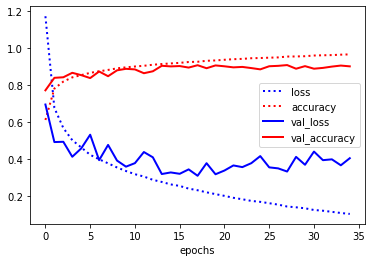

In [52]:
def build_model_4_1():
    conv_base = applications.vgg16.VGG16(weights='imagenet',
                                         include_top=False,
                                         input_shape=(32, 32, 3))
    
    model = models.Sequential()
    model.add(conv_base)
    
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2**11, kernel_constraint=constraints.MaxNorm(2)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(.01))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, kernel_constraint=constraints.MaxNorm(2), activation='softmax'))

    conv_base.trainable = True
    set_trainable = False
    for layer in conv_base.layers:
        if layer.name == 'block4_conv2':
            set_trainable = True
        layer.trainable = set_trainable
        
    model.compile(optimizer=optimizers.SGD(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    return model


train_data_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=.05,
    fill_mode='nearest',
)
X_train_pre, X_val_pre, y_train, y_val= evaluation_split
train_data_gen.fit(X_train_pre)
it_train = train_data_gen.flow(x=X_train_pre, y=y_train, batch_size=64)
steps = int(X_train_pre.shape[0] / 64)
augmented_split = it_train, X_val_pre, y_val

run_evaluation("model_4_1", build_model_4_1, augmented_split, base_dir,
               steps_per_epoch=steps, generator=True,
               train=False, epochs=35, batch_size=64)
answer_q_4_1 = """The final model has a val accuracy of 91%.
Unfreezing more layers helps a lot. Without unfreezing any layers my validation accuracy didn't get above 70%.
In the end I unfroze 4 layers (block4_conv2 and further), which performs well while still keeping the training times reasonably low.
Again I used a simple optimizer (to keep the save size low) and a dense layer with LeakyReLu activation, dropout, batchnormalization and maxnorm.
"""
print("Answer is {} characters long".format(len(answer_q_4_1)))

### Question 4.2 Embeddings and pipelines (5 points)
- Generate embeddings of the original images by running them through the trained convolutional part of model_4_1 (without the dense layer) and returning the output. Embed the training and test data and store them to disk using the helper functions below. Implement a function `store_embeddings` that loads model_4_1 and stores all necessary embeddings to file. Make sure to run it once so that the embeddings are stored (and submitted).
- Implement a function 'generate_pipeline' that returns an scikit-learn pipeline. You can use any non-deep learning technique (eg. SVMs, RFs,...), and preprocessing technique. You can do model selection using the validation set. 
- Implement a function 'evaluate_pipeline' that evaluates a given pipeline on a given training and test set. 
- Implement a function 'evaluation_4_2' that evaluates your pipeline on the embedded training and test set (loaded from file) and returns the accuracy. 
- Describe what you did and what you observed. Report the obtained accuracy score. Can you beat your best model thus far?

In [38]:
def store_embedding(X, name):  
    with gzip.open(os.path.join(base_dir, name+'_embedding.p'), 'wb') as file_pi:
        pickle.dump(X, file_pi)

        
def load_embedding(name):
    with gzip.open(os.path.join(base_dir, name+'_embedding.p'), 'rb') as file_pi:
        return pickle.load(file_pi)

    
def store_embeddings():
    """ Stores all necessary embeddings to file
    """
    model = load_model_from_file(base_dir, 'model_4_1').layers[0] # layer 0 is last layer before flatten and dense layers.
    store_embedding(model.predict(X_train), 'model_4_1_train')
    store_embedding(model.predict(X_val), 'model_4_1_val')
    store_embedding(model.predict(X_test), 'model_4_1_test')

    
def load_embeddings():
    return load_embedding('model_4_1_train'), load_embedding('model_4_1_val'), load_embedding('model_4_1_test')

    
def generate_pipeline():
    """ Returns an sklearn pipeline.
    """
    return Pipeline(steps=[
        ('transform', FunctionTransformer(lambda x: x.reshape((x.shape[0], x.shape[-1])))), 
        ('pca', PCA()), 
        ('clf', RandomForestClassifier())
    ])


def evaluate_pipeline(pipeline, X_train, y_train, X_test, y_test):
    """ Evaluates the given pipeline, trained on the given embedded training set and 
        evaluated on the supplied embedded test set. Returns the accuracy score.
    """
    pipeline = pipeline.fit(X_train, y_train)
    return pipeline.score(X_train, y_train), pipeline.score(X_test, y_test) # train and test accuracy


def evaluation_4_2(X_train, y_train, X_test, y_test):
    """ Runs 'evaluate_pipeline' with embedded versions of the input data 
    and returns the accuracy.
    """
    model = load_model_from_file(base_dir, 'model_4_1').layers[0] # layer 0 is last layer before flatten and dense layers.
    pipeline = generate_pipeline().fit(
        model.predict(X_train),
        np.argmax(y_train, axis=1)
    )
    return pipeline.score(
        model.predict(X_test),
        np.argmax(y_test, axis=1)
    )


answer_q_4_2 = """After testing multiple techniques, random forest performed the best with 98% train accuracy and 89% test accuracy on the embedded data.
The original images perform quite bad (as expected) and only get to 24% accuracy with the same pipeline.
The pipeline first flattend the images to the right shape with a lambda function and then transforms the data.
Then PCA is used to reduce the size of the parameters, which improved the running time and finally the random forest classifier.
"""
print("Pipeline:", generate_pipeline())
print("Answer is {} characters long".format(len(answer_q_4_2)))

Pipeline: Pipeline(memory=None,
         steps=[('transform',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function generate_pipeline.<locals>.<lambda> at 0x00000243FD8DE310>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args=None, validate=False)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=Fa...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                  

In [39]:
# # running the avaluation
# emb_X_train, emb_X_val, emb_X_test = load_embeddings()
# eval_accuracy = evaluation_4_2(emb_X_train, y_train, emb_X_test, y_test)